### Trajectory Optimization
1. Trajectory optimization is concerned with finding the optimal trajectory given some objective functions, for example minimal force or minimal work:
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 u^2 (\tau) d\tau$$
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 |u (\tau) v(\tau)| d\tau$$

2. A standard trajectory optimization problem consists of two terms, a *mayer* term that captures boundary conditions and a *lagrange* term that is a path integral along the entire trajectory:
<br> $$\min_{t_0,t_f,u(t),\mathbf{x}(t),\mathbf{v}(t)} J(t_0,t_f,\mathbf{x}(t_0),\mathbf{x}(t_f)) + \int_{t_0}^{t_f} w(\tau,\mathbf{x}(\tau),\mathbf{u}(\tau)) d\tau$$

#### Direct Collocation Methods
1. Direct collocation operates by transcribing a trajectory generation problem in to a nonlinear program.

2. Simple example: Consider moving a unit mass from rest at $x=0$ to stop at $x=1$ in $1$ second.
<br> $$\min_{u(t),x(t),v(t)} \int_{0}^1 u^2 (\tau) d\tau$$
<br> $$u^* = 6-12t, x^* = 3t^2 - 2t^3$$
where the second euqation is found from calculus of variations

3. To begin, we need to discretize the trajectory, which gives a finite set of decision variables. This is done by setting up collocation points:
$$t \rightarrow t_0 ... t_k ... t_N$$
$$x \rightarrow x_0 ... x_k ... x_N$$
$$v \rightarrow v_0 ... v_k ... v_N$$
Using trapezoidal collocation, we approximate the change in state in the continuous function $\dot x = v$ as $x_{k+1}-x_k \approx \frac{1}{2} h_k (v_{k+1}+v_k)$. Also, for $\ddot x = u$, we have $v_{k+1}-v_k \approx \frac{1}{2} h_k (u_{k+1}+u_k)$. The boundary conditions are $x_0 = v_0 = v_N = 0$ and $x_N = 1$. Discretizing the objective function, we have:
<br> $$\min_{u(t)} \int_{t_0}^{t_N} u^2 (\tau) d\tau \approx \min_{u_0 .. u_N} \sum_{k=0}^{N-1} \frac{1}{2} h_k (u_k^2+u_{k+1}^2)$$

4. *Initialization* - to kickstart the nonlinear program, we need initial guesses. A simple trajectory for our problem is a ramp. Evaluating the guessed trajectory at each collocation point, we can obtain values to pass to the nonlinear program

5. *Interpolation* - To reconstruct trajectories from the knot points, we construct the conrol trajectory as a piece-wise linear function, i.e. $u(t) \approx u_k + \frac{\tau}{h_k}(u_{k+1}-u_k)$ where $\tau = t-t_k$ and $h_k = t_{k+1}-t_k$. The state trajectory, however, is represented by a quadratic spline. This is because the dynamics was approximated as a linear function, $f(t) = \dot x(t) \approx f_k + \frac{\tau}{h_k}(f_{k+1}-f_k)$. To recover $x(t)$, we will need to integrate the linear function, resulting in the quadratic $x(t) \approx x_k + f_k \tau + \frac{\tau^2}{2h_k}(f_{k+1}-f_k)$

##### Example 1: Double integrator

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      804
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

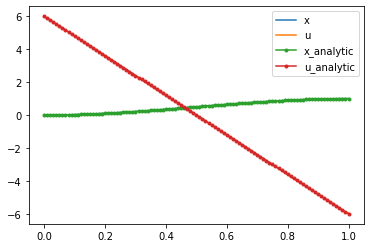

In [5]:
# Example 1: moving a unit mass from x=0 to x=1 in 1s. Here control is unbounded.
# To add actuation saturation, simply include "opti.subject_to(u <= 5)" and "opti.subject_to(-5 <= u)"
# requires casadi, simply run "pip install casadi" to install
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

N = 100
T = 1
hk = T/N

# analytic solution
t = np.linspace(0,T,N+1);
u_analytic = 6-12*t
x_analytic = 3*np.power(t,2) - 2*np.power(t,3)

# nonlinear optimization
opti = casadi.Opti()
x = opti.variable(N+1) # 0~N
v = opti.variable(N+1)
u = opti.variable(N+1)

# constraints with trapezoidal quadrature
opti.subject_to(x[0] == 0)
opti.subject_to(v[0] == 0)
opti.subject_to(x[N] == 1)
opti.subject_to(v[N] == 0)
for k in range(N):
    opti.subject_to(x[k+1] - x[k] == 0.5 * hk * (v[k+1] + v[k]))
    opti.subject_to(v[k+1] - v[k] == 0.5 * hk * (u[k+1] + u[k]))

# objective function
opti.minimize(0.5*hk*sumsqr(u[0:N])+0.5*hk*sumsqr(u[1:N+1]))

# initial guess
opti.set_initial(x, np.linspace(0,1,N+1))
opti.set_initial(v, np.ones((1,N+1)))
opti.set_initial(u, np.zeros((1,N+1)))

# solve
opti.solver("ipopt") #,p_opts, s_opts)
sol = opti.solve()

# solution
plt.plot(t, sol.value(x), label="x")
plt.plot(t, sol.value(u), label="u")
plt.plot(t, x_analytic, label="x_analytic", marker='.')
plt.plot(t, u_analytic, label="u_analytic", marker='.')
plt.legend()
plt.show()

##### Example 2: Cart pole swing up
![cart_pole](resource/cart_pole.png)

The equations of motion are given by:
$$\ddot q_1 = \frac{L m_2 sin(q_2) \dot q_2^2 + u + m_2 g cos(q_2) sin(q_2)}{m_1 + m_2 (1-cos^2(q_2))}$$
$$\ddot q_2 = \frac{L m_2 cos(q_2) sin(q_2) \dot q_2^2 + u cos (q_2) + (m_1 + m_2) g sikn(q_2)}{L m_1 + L m_2 (1-cos^2(q_2))}$$

And the state vector is given by $$x = \begin{bmatrix} q_1 \\ q_2 \\ \dot q_1 \\ \dot q_2 \end{bmatrix}$$


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2008
Number of nonzeros in inequality constraint Jacobian.:      606
Number of nonzeros in Lagrangian Hessian.............:      303

Total number of variables............................:      505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

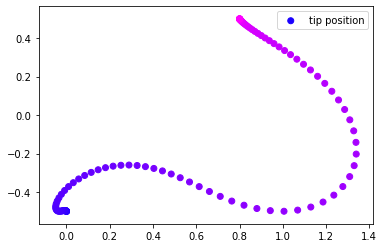

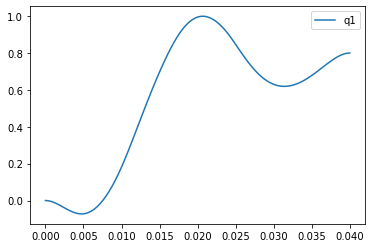

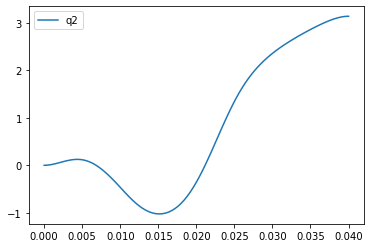

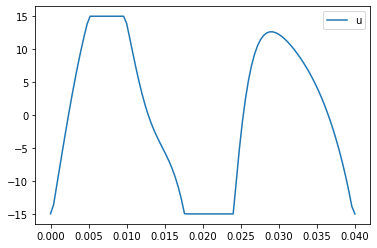

In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import math

N = 100
T = 2
hk = T/N

m1 = 2
m2 = 0.5
g = 9.81
L = 0.5

dist = 0.8
umax = 15

# nonlinear optimization
opti = casadi.Opti()
q1 = opti.variable(N+1) # 0~N
q2 = opti.variable(N+1)
dq1 = opti.variable(N+1)
dq2 = opti.variable(N+1)
u = opti.variable(N+1)

# constraints with trapezoidal quadrature
opti.subject_to(q1[0] == 0)
opti.subject_to(q2[0] == 0)
opti.subject_to(q1[N] == dist)
opti.subject_to(q2[N] == math.pi)
opti.subject_to(dq1[0] == 0)
opti.subject_to(dq2[0] == 0)
opti.subject_to(dq1[N] == 0)
opti.subject_to(dq2[N] == 0)

opti.subject_to(q1 <= 2*dist)
opti.subject_to(-2*dist <= q1)
opti.subject_to(q2 <= 2*math.pi)
opti.subject_to(-2*math.pi <= q2)
opti.subject_to(u <= umax)
opti.subject_to(-umax <= u)

# ddq1[k] = (L*m2*sin(q2[k])*q2[k]**2+u[k]+m2*g*cos(q2[k])*sin(q2[k]))/(m1+m2*(1-cos(q2[k])**2))
# ddq2[k] = -(L*m2*cos(q2[k])*sin(q2[k])*q2[k]**2+u[k]*cos(q2[k])+(m1+m2)*g*sin(q2[k]))/(L*m1+L*m2*(1-cos(q2[k])**2))

for k in range(N):
    opti.subject_to(q1[k+1] - q1[k] == 0.5 * hk * (dq1[k+1] + dq1[k]))
    opti.subject_to(dq1[k+1] - dq1[k] == 0.5 * hk * ( (L*m2*sin(q2[k+1])*q2[k+1]**2+u[k+1]+m2*g*cos(q2[k+1])*sin(q2[k+1]))/(m1+m2*(1-cos(q2[k+1])**2)) + 
                                                      (L*m2*sin(q2[k])*q2[k]**2+u[k]+m2*g*cos(q2[k])*sin(q2[k]))/(m1+m2*(1-cos(q2[k])**2)) ))
    opti.subject_to(q2[k+1] - q2[k] == 0.5 * hk * (dq2[k+1] + dq2[k]))
    opti.subject_to(dq2[k+1] - dq2[k] == 0.5 * hk * ( -(L*m2*cos(q2[k+1])*sin(q2[k+1])*q2[k+1]**2+u[k+1]*cos(q2[k+1])+(m1+m2)*g*sin(q2[k+1]))/(L*m1+L*m2*(1-cos(q2[k+1])**2)) 
                                                      -(L*m2*cos(q2[k])*sin(q2[k])*q2[k]**2+u[k]*cos(q2[k])+(m1+m2)*g*sin(q2[k]))/(L*m1+L*m2*(1-cos(q2[k])**2))))
    
# objective function
opti.minimize(0.5*hk*sumsqr(u[0:N])+0.5*hk*sumsqr(u[1:N+1]))

# initial guess
t = hk*np.linspace(0,T,N+1);
opti.set_initial(q1, t/T*dist)
opti.set_initial(q2, t/T*math.pi)
opti.set_initial(u, 0*t)

# solve
opti.solver("ipopt") #,p_opts, s_opts)
sol = opti.solve()

# plot kinematics
x = (sol.value(q1) + L*sin(sol.value(q2)))
y = (-L*cos(sol.value(q2)))
x_ = np.array(x)
y_ = np.array(y)
alp = np.linspace(0.1,1,len(x_))
plt.scatter(x_, y_, marker='o', color=np.asarray([(a, 0, 1, 1) for a in alp]), label="tip position")
plt.legend()
plt.show()

# plot states
plt.plot(t, sol.value(q1), label="q1")
plt.legend()
plt.show()

plt.plot(t, sol.value(q2), label="q2")
plt.legend()
plt.show()

plt.plot(t, sol.value(u), label="u")
plt.legend()
plt.show()

# for pybullet
q1_ = np.array(sol.value(q1))
q2_ = np.array(sol.value(q2))

In [10]:
import pybullet as p
import time
import pybullet_data

DT = hk
slowdown = 2

physicsClient = p.connect(p.GUI)#or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath()) #used by loadURDF
p.setGravity(0, 0, -9.81)
p.setRealTimeSimulation(0)
p.setTimeStep(DT)

# Import cart pole
planeId = p.loadURDF("plane.urdf")
startPos = [0,0,1.5]
startOrientation = p.getQuaternionFromEuler([0,0,0])
cartPoleId = p.loadURDF("./resource/cart_pole.urdf",startPos, startOrientation)

# Free the joints
p.setJointMotorControl2(cartPoleId, 0, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(cartPoleId, 1, p.VELOCITY_CONTROL, force=0)

# Setup torque control

# Simulate
for i in range(q1_.size):
    p.resetJointState(cartPoleId,0,q1_[i])
    p.resetJointState(cartPoleId,1,q2_[i])
    p.stepSimulation()
    time.sleep(slowdown*DT)
p.disconnect()